# Notes
Did my first read of the paper. It's super interesting and well written and has a lot of nice insights and data. I enjoyed how it also presented some reasons as to why ReLU works from a neuroscience / biological perspective.

### Introduction

The relu activation function or max(0,x) is interesting because it both has better performance but is also quite similar to our biological neurons. In the paper they use relu + an L1 regularizer to promote sparsity, which they claim have many nice effects / properties for the network.

### Background

There are several phenomena / observations of how the brain works that are similar to the types of network that using Relu activation functions creates. Firstly the brain has sparse activations. It's estimated that between 1-4% of neurons in the brain are activate at one time. With sigmoid, when it receives a zero input (it's steady state), we get an output of around 1/2. This means that upon initialization, on average, all neurons are firing at 1/2. Additionally biological models of neuron activations have a threshold to fire, and below that threshold they don't fire. Relu has that threshold where it just doesn't fire, at < 0.

Sparsity in networks has some claimed advantages. It allows for more disentangled "clean" models. This seemingly makes the models more robust as with highly entangled models where everything is activating everything, a small change in the input can modify weights / activations in the entire model. In a sparse model, small changes in the input affect less of the entire model.

Sparse representations are more likely to be linearly seperable. This makes sense to me. When we have kind of a wide layer we're projecting the data into a higher-dimensional space. But if all the points in that higher dimensional space need to be considered then it becomes kind of a challenge, likely what will happen is that it becomes overfit, where our linearly seperable bound becomes some weird contorted shape to fit everything. If we make it spare however, then when we go to that higher dimensional space, we have less unique points to fit as a bunch will just be 0s. So we get the more useful features in that space and then have to fit that. So it's kind of like a regularization?

It's important to not go too hard on sparsity as it could affect the performance and reduce the effective capacity.

### Deep Rectifier Networks

What's nice about relu is that after uniform initialization of weights we can expect around 50% of units to output 0s. The non-linearity in the network comes from the path selection. For a given input the computation is actually linear. The network is linear by parts. Gradients flow nicer and there's no vanishing gradient problem.

One of the potential problems listed is that "the hard saturation at 0 may hurt optimization by blocking gradient back-propogation". This means that some may think that it's a problem that the gradient just dies and stops flowing at 0. But they test a similar looking smooth version soft plus and see that the hard 0 actually can help.

Another issue is that because the activation is unbounded, in that the limit is infinity, so we may get some huge numbers. To combat this we use an L1 penalty / regularization.

Last note is that relu networks are subject to "ill-conditioning of the parametrization". This means that because there are infinitely many weights that produce the exact same network function, the optimizers job becomes harder. It can get stuck between equivalent solutions or take unbalanced update steps making the process unstable. This might look like [this](https://doimages.nyc3.cdn.digitaloceanspaces.com/010AI-ML/content/images/2018/06/patho3.png) from this blog post.

Note: At 0 the function is technically not differentiable, so in practice if the activation is 0 then we set the gradient to 0.

Side note: I wonder if it's computationally more efficient as well. Gradient is easier to compute and also the value is easier to compute. It makes sense, [this discussion](https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks) seems to suggest it as well

In [2]:
# compare tanh, relu, sigmoid and softplus on same training I had from lenet with MLP
from tensorflow.keras.datasets import mnist
import torch

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
print(len(x_train), len(x_test))

60000 10000


In [3]:
import random
import math

class Fully_Connected_Layer():
    def __init__(self, nin, nout, activation_function):
        self.w = torch.randn(nin, nout)
        self.w.mul_(math.sqrt(2.0 / nin)) 
        self.w.requires_grad_()                 
        self.b = torch.randn(nout, requires_grad=True)
        self.activation_function = activation_function

    def __call__(self, x):
        act = (x @ self.w) + self.b
        if(self.activation_function == "relu"):
            return torch.relu(act)
        if(self.activation_function == "tanh"):
            return torch.tanh(act)
        if(self.activation_function == "sigmoid"):
            return torch.sigmoid(act)
        if(self.activation_function == "softplus"):
            return torch.nn.Softplus()(act)
        return act

    def parameters(self):
        return [self.w, self.b]

class MLP():
    def __init__(self, nin, nouts, activation_function):
        sz = [nin] + nouts
        self.layers = [Fully_Connected_Layer(sz[i], sz[i+1], activation_function) for i in range(len(nouts)- 1)]
        self.layers.append(Fully_Connected_Layer(sz[-2], sz[-1], "none"))
        self.activation_function = activation_function

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [4]:
def loss_individual(model_outputs, target_label_index):
    max_logit = torch.max(model_outputs)
    shifted_logits = model_outputs - max_logit
    exp = torch.exp(shifted_logits)
    sum_exp = torch.sum(exp)
    target_exp = exp[target_label_index]
    softmax_target = target_exp / sum_exp

    # negative log liklihood
    eps = 1e-12
    loss = -torch.log(softmax_target + eps)
    return loss


--- Training with activation: relu ---
epoch done...
epoch done...
Finished relu in 73.85 seconds

--- Training with activation: tanh ---
epoch done...
epoch done...
Finished tanh in 71.10 seconds

--- Training with activation: sigmoid ---
epoch done...
epoch done...
Finished sigmoid in 72.58 seconds

--- Training with activation: softplus ---
epoch done...
epoch done...
Finished softplus in 76.81 seconds


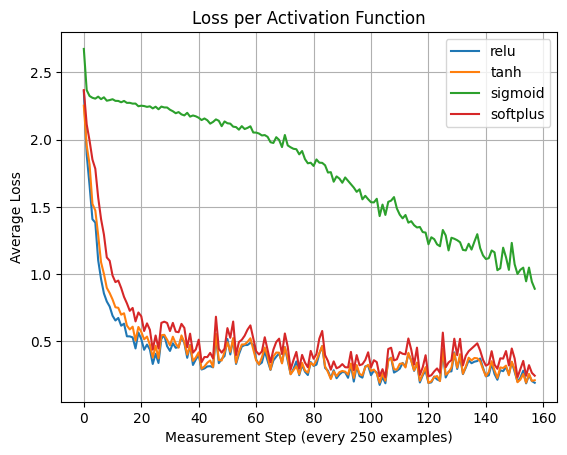

In [29]:
import matplotlib.pyplot as plt
import time


activations = ["relu", "tanh", "sigmoid", "softplus"] 
losses_by_activation = {}

for act in activations:
    print(f"\n--- Training with activation: {act} ---")
    start_time = time.time()
    
    lossi = []
    mnist_mlp = MLP(28*28, [256, 256, 10], act)
    learning_rate = 0.001
    lambda_val = 0.0001
    print_reset_error_interval = 250
    cumulative_error = 0
    count = 0
    epochs = 2
    examples_per_epoch = 20000

    for epoch in range(epochs):
        cumulative_error = 0
        for i in range(examples_per_epoch):
            flattened = torch.flatten(x_train[i])
            out = mnist_mlp(flattened)
            weights_sum = None
            for p in mnist_mlp.parameters():
                if(p.dim() > 1):
                    square = torch.square(p)
                    sum = square.sum()
                    weights_sum = sum if weights_sum is None else weights_sum + sum
            loss = loss_individual(out, y_train[i].item()) + lambda_val * weights_sum
            loss.backward()
            with torch.no_grad():
                cumulative_error += loss_individual(out, y_train[i].item()).item()
            count += 1
            with torch.no_grad():
                for p in mnist_mlp.parameters():
                    p -= learning_rate * p.grad
                    p.grad.zero_()
            if(i % print_reset_error_interval == 0 and i != 0):
                lossi.append(cumulative_error / print_reset_error_interval)
                cumulative_error = 0
        print("epoch done...")

    losses_by_activation[act] = lossi
    end_time = time.time()
    duration = end_time - start_time
    print(f"Finished {act} in {duration:.2f} seconds")

# Plot all on the same chart
for act, losses in losses_by_activation.items():
    plt.plot(losses, label=act)

plt.xlabel('Measurement Step (every 250 examples)')
plt.ylabel('Average Loss')
plt.title('Loss per Activation Function')
plt.grid(True)
plt.legend()
plt.show()



--- Training with activation: relu ---
epoch done...
epoch done...
Finished relu in 42.32 seconds

--- Training with activation: tanh ---
epoch done...
epoch done...
Finished tanh in 40.59 seconds

--- Training with activation: sigmoid ---
epoch done...
epoch done...
Finished sigmoid in 40.36 seconds

--- Training with activation: softplus ---
epoch done...
epoch done...
Finished softplus in 41.50 seconds


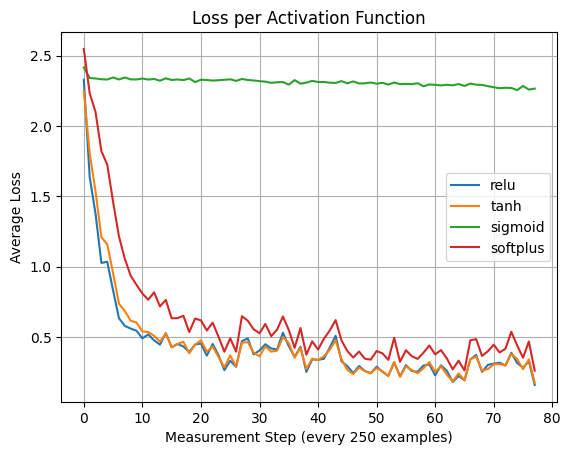

In [5]:
# scaling it up more to see how it works

import matplotlib.pyplot as plt
import time


activations = ["relu", "tanh", "sigmoid", "softplus"] 
losses_by_activation = {}

for act in activations:
    print(f"\n--- Training with activation: {act} ---")
    start_time = time.time()
    
    lossi = []
    mnist_mlp = MLP(28*28, [256, 256, 256, 10], act)
    learning_rate = 0.0015
    lambda_val = 0.0001
    print_reset_error_interval = 250
    cumulative_error = 0
    count = 0
    epochs = 2
    examples_per_epoch = 10000

    for epoch in range(epochs):
        cumulative_error = 0
        for i in range(examples_per_epoch):
            flattened = torch.flatten(x_train[i])
            out = mnist_mlp(flattened)
            weights_sum = None
            for p in mnist_mlp.parameters():
                if(p.dim() > 1):
                    square = torch.square(p)
                    sum = square.sum()
                    weights_sum = sum if weights_sum is None else weights_sum + sum
            loss = loss_individual(out, y_train[i].item()) + lambda_val * weights_sum
            loss.backward()
            with torch.no_grad():
                cumulative_error += loss_individual(out, y_train[i].item()).item()
            count += 1
            with torch.no_grad():
                for p in mnist_mlp.parameters():
                    p -= learning_rate * p.grad
                    p.grad.zero_()
            if(i % print_reset_error_interval == 0 and i != 0):
                lossi.append(cumulative_error / print_reset_error_interval)
                cumulative_error = 0
        print("epoch done...")

    losses_by_activation[act] = lossi
    end_time = time.time()
    duration = end_time - start_time
    print(f"Finished {act} in {duration:.2f} seconds")

# Plot all on the same chart
for act, losses in losses_by_activation.items():
    plt.plot(losses, label=act)

plt.xlabel('Measurement Step (every 250 examples)')
plt.ylabel('Average Loss')
plt.title('Loss per Activation Function')
plt.grid(True)
plt.legend()
plt.show()


--- Training with activation: relu ---
epoch done...
epoch done...
Finished relu in 23.70 seconds

--- Training with activation: tanh ---
epoch done...
epoch done...
Finished tanh in 24.81 seconds

--- Training with activation: sigmoid ---
epoch done...
epoch done...
Finished sigmoid in 25.00 seconds

--- Training with activation: softplus ---
epoch done...
epoch done...
Finished softplus in 25.36 seconds


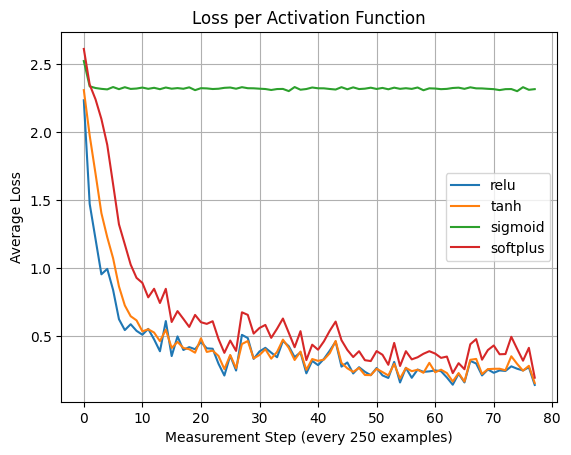

In [6]:
# testing with a deeper network

import matplotlib.pyplot as plt
import time


activations = ["relu", "tanh", "sigmoid", "softplus"] 
losses_by_activation = {}

for act in activations:
    print(f"\n--- Training with activation: {act} ---")
    start_time = time.time()
    
    lossi = []
    mnist_mlp = MLP(28*28, [128, 128, 128, 128, 128, 10], act)
    learning_rate = 0.0018
    lambda_val = 0.0001
    print_reset_error_interval = 250
    cumulative_error = 0
    count = 0
    epochs = 2
    examples_per_epoch = 10000

    for epoch in range(epochs):
        cumulative_error = 0
        for i in range(examples_per_epoch):
            flattened = torch.flatten(x_train[i])
            out = mnist_mlp(flattened)
            weights_sum = None
            for p in mnist_mlp.parameters():
                if(p.dim() > 1):
                    square = torch.square(p)
                    sum = square.sum()
                    weights_sum = sum if weights_sum is None else weights_sum + sum
            loss = loss_individual(out, y_train[i].item()) + lambda_val * weights_sum
            loss.backward()
            with torch.no_grad():
                cumulative_error += loss_individual(out, y_train[i].item()).item()
            count += 1
            with torch.no_grad():
                for p in mnist_mlp.parameters():
                    p -= learning_rate * p.grad
                    p.grad.zero_()
            if(i % print_reset_error_interval == 0 and i != 0):
                lossi.append(cumulative_error / print_reset_error_interval)
                cumulative_error = 0
        print("epoch done...")

    losses_by_activation[act] = lossi
    end_time = time.time()
    duration = end_time - start_time
    print(f"Finished {act} in {duration:.2f} seconds")

for act, losses in losses_by_activation.items():
    plt.plot(losses, label=act)

plt.xlabel('Measurement Step (every 250 examples)')
plt.ylabel('Average Loss')
plt.title('Loss per Activation Function')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
# add some way to track sparsity and print it out to see how the sparsity emerges in relu networks compared to other types

import random
import math

class Fully_Connected_Layer():
    def __init__(self, nin, nout, activation_function):
        self.w = torch.randn(nin, nout)
        self.w.mul_(math.sqrt(2.0 / nin)) 
        self.w.requires_grad_()                 
        self.b = torch.randn(nout, requires_grad=True)
        self.activation_function = activation_function

    def __call__(self, x):
        act = (x @ self.w) + self.b
        if(self.activation_function == "relu"):
            return torch.relu(act)
        if(self.activation_function == "tanh"):
            return torch.tanh(act)
        if(self.activation_function == "sigmoid"):
            return torch.sigmoid(act)
        if(self.activation_function == "softplus"):
            return torch.nn.Softplus()(act)
        return act

    def parameters(self):
        return [self.w, self.b]
        
    def sparsity(self, eps: float = 0.0) -> float:
            zeros = torch.count_nonzero(self.w.abs() <= eps).item()
            return zeros / self.w.numel()

class MLP():
    def __init__(self, nin, nouts, activation_function):
        sz = [nin] + nouts
        self.layers = [Fully_Connected_Layer(sz[i], sz[i+1], activation_function) for i in range(len(nouts)- 1)]
        self.layers.append(Fully_Connected_Layer(sz[-2], sz[-1], "none"))
        self.activation_function = activation_function

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    def sparsity(self, eps: float = 0.0, verbose: bool = True) -> float:
        total_zeros, total_params = 0, 0
        for i, layer in enumerate(self.layers):
            s = layer.sparsity(eps)
            if verbose:
                print(f"layer {i:<2}: {s*100:6.2f}% zero")
            total_zeros   += torch.count_nonzero(layer.w.abs() <= eps).item()
            total_params  += layer.w.numel()
        net_sparsity = total_zeros / total_params
        if verbose:
            print("-" * 22)
            print(f"network : {net_sparsity*100:6.2f}% zero")
        return net_sparsity

In [ ]:
# scaling it up more to see how it works

import matplotlib.pyplot as plt
import time


activations = ["relu", "tanh", "sigmoid", "softplus"] 
losses_by_activation = {}

for act in activations:
    print(f"\n--- Training with activation: {act} ---")
    start_time = time.time()
    
    lossi = []
    mnist_mlp = MLP(28*28, [256, 256, 256, 10], act)
    learning_rate = 0.0015
    lambda_val = 0.0003
    print_reset_error_interval = 250
    cumulative_error = 0
    count = 0
    epochs = 3
    examples_per_epoch = 25000

    for epoch in range(epochs):
        cumulative_error = 0
        for i in range(examples_per_epoch):
            flattened = torch.flatten(x_train[i])
            out = mnist_mlp(flattened)
            weights_sum = None
            for p in mnist_mlp.parameters():
                if(p.dim() > 1):
                    square = torch.square(p)
                    sum = square.sum()
                    weights_sum = sum if weights_sum is None else weights_sum + sum
            loss = loss_individual(out, y_train[i].item()) + lambda_val * weights_sum
            loss.backward()
            with torch.no_grad():
                cumulative_error += loss_individual(out, y_train[i].item()).item()
            count += 1
            with torch.no_grad():
                for p in mnist_mlp.parameters():
                    p -= learning_rate * p.grad
                    p.grad.zero_()
            if(i % print_reset_error_interval == 0 and i != 0):
                lossi.append(cumulative_error / print_reset_error_interval)
                cumulative_error = 0
        print("epoch done...")

    losses_by_activation[act] = lossi
    net_sparsity = mnist_mlp.sparsity(eps=1e-3, verbose=False)       
    final_loss   = lossi[-1] if lossi else float("nan")       
    print(f"Sparsity: {net_sparsity*100:6.2f}% | Final avg loss: {final_loss:.4f}")
    end_time = time.time()
    duration = end_time - start_time
    print(f"Finished {act} in {duration:.2f} seconds")


for act, losses in losses_by_activation.items():
    plt.plot(losses, label=act)

plt.xlabel('Measurement Step (every 250 examples)')
plt.ylabel('Average Loss')
plt.title('Loss per Activation Function')
plt.grid(True)
plt.legend()
plt.show()


--- Training with activation: relu ---
epoch done...
epoch done...
epoch done...
Sparsity:   1.39% | Final avg loss: 0.1576
Finished relu in 151.33 seconds

--- Training with activation: tanh ---
epoch done...
